# Análisis exploratorio de las publicaciones con descuento del marketplace

Análisis Orientado - Definición de preguntas:
* ¿Cuál es la proporción de items con descuentos de cada categoría?
* ¿Cuántos productos con descuento tenemos en televisores? ¿y en 
celulares?  
* ¿Cual es el descuento promedio en distintas categorías del 
marketplace?  
* ¿Cuál es la relación entre el precio original del producto y el descuento aplicado?
* ¿Qué relación existe entre los vendedores (reputación, # de ventas) y los descuentos?

# 0. Importar librerías base

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import  matplotlib.pyplot as plt
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')

# 1. Importar Data

## 1.1 Importar Dataset Base
El Dataset base tiene 26k registros de las categorías TOP de publicaciones. Contiene información general de los items (search_enpoint), información de los vendedores (users_endpoint) y las fechas de publicación (item_endpoint).

La cantidad de regsitros es limitada por el tiempo de consulta y las políticas de la API que limitan el consumo

In [3]:
df_base = pd.read_csv('../data/dataset_base.csv')
df_base.sample(3)

,ID,TITLE,PRICE,ORIGINAL_PRICE,AVAILABLE_QUANTITY,BUYING_MODE,LISTING_TYPE_ID,ACCEPTS_MERCADOPAGO,CATEGORIA_CODE,condition,shipping.free_shipping,catalog_listing,last_updated,date_created,seller.id,seller.nickname,seller_reputation.level_id,seller_reputation.power_seller_status,seller_reputation.transactions.total
18880,MLA1369266413,Vinilo Vivencia Mi Cuarto Lp,33989.00,NaN,1,buy_it_now,gold_special,1,MLA1168,new,1,1,2024-06-08T17:07:02.568Z,2023-05-11T01:12:32.000Z,44739616,LEFCASADEMUSICA,5_green,platinum,53645
16008,MLA1686509828,Aspiradora Ultracomb As-4201 1400w 2l Trineo B...,115804.10,NaN,1,buy_it_now,gold_pro,1,MLA5726,new,1,1,2024-06-12T22:16:41.586Z,2024-02-29T15:57:24.000Z,253480319,ELECTRICIDADSEGADOSAELECTR,5_green,platinum,7112
21681,MLA1695662630,Mochila Wilson Mujer Urbana Deportes Gym Porta...,34104.05,35899.0,1,buy_it_now,gold_special,1,MLA1430,new,1,1,2024-06-11T23:50:15.000Z,2024-03-07T13:01:40.000Z,35558203,JLSHOP.,5_green,gold,3196


## 1.2 Importar Dataset Search May
El Dataset search tiene 912k registros. Contiene información general de los items para todas las 32 categorías del Market Place en Mayo 2024.

In [7]:
df_search = pd.read_csv('../data/dataset_search.csv')
df_search.sample(3)

,id,title,condition,price,original_price,available_quantity,buying_mode,listing_type_id,accepts_mercadopago,CATEGORIA_CODE,shipping.free_shipping,catalog_listing
60487,MLA1614599134,Reloj Inteligente Smartwatch Z59 Ultra Bluetoo...,new,18338.80,19304.0,1,buy_it_now,gold_pro,True,MLA1051,False,True
255250,MLA1621669450,Mascarilla Elimina Puntos Negros X10 Unidades ...,new,3422.93,NaN,1,buy_it_now,gold_special,True,MLA1246,False,True
512076,MLA1414072393,Corredera Telescópica Bronzen Guía Cajón 450mm...,new,4699.00,NaN,1,buy_it_now,gold_special,True,MLA1500,False,True


## 1.3 Info de IDs categorías - Nombre Categorías
Nombre y ID de las 32 categorías del MarketPlace de Argentina (MLA)

In [8]:
df_cat = pd.read_csv('../data/categories_MLA.csv')
df_cat.sample(5)

,id,name
29,MLA1540,Servicios
19,MLA1574,"Hogar, Muebles y Jardín"
23,MLA3937,Joyas y Relojes
17,MLA2547,Entradas para Eventos
10,MLA1051,Celulares y Teléfonos


## 1.4 Datasets + Nombre_Categoría
Complementar los datasets (Base y search) con el nombre de la categoría para el análisis

In [10]:
print(len(df_base))
df_base_full = pd.merge(df_base, df_cat, left_on='CATEGORIA_CODE', right_on='id', indicator='flag', how='inner')
print(len(df_base_full))

print(len(df_search))
df_search_full = pd.merge(df_search, df_cat, left_on='CATEGORIA_CODE', right_on='id', indicator='flag', how='inner')
print(len(df_search_full))
df_search_full['flag'].value_counts()

25944
25944
912102
912102


flag
both          912102
left_only          0
right_only         0
Name: count, dtype: int64

In [11]:
df_base_full = df_base_full[['ID', 'TITLE', 'PRICE', 'ORIGINAL_PRICE', 'AVAILABLE_QUANTITY',
       'BUYING_MODE', 'LISTING_TYPE_ID', 'ACCEPTS_MERCADOPAGO',
       'CATEGORIA_CODE', 'condition', 'shipping.free_shipping',
       'catalog_listing', 'last_updated', 'date_created', 'seller.id',
       'seller.nickname', 'seller_reputation.level_id',
       'seller_reputation.power_seller_status',
       'seller_reputation.transactions.total','name']]

df_base_full = df_base_full.rename(columns={
    'name': 'CATEGORY_NM'
})

df_search_full = df_search_full[['id_x', 'title', 'price', 'original_price', 'available_quantity', 'buying_mode',
                                   'listing_type_id', 'accepts_mercadopago','CATEGORIA_CODE', 'condition', 'shipping.free_shipping', 'catalog_listing', 'name']]

df_search_full = df_search_full.rename(columns={
    'id_x':'id_item',
    'name': 'CATEGORY_NM'
})

# 2. Análisis

In [12]:
df_search_full['flag_discount'] = ~df_search_full.original_price.isnull()
df_base_full['flag_discount'] = ~df_base_full.ORIGINAL_PRICE.isnull()
df_search_full.sample(3)

,id_item,title,price,original_price,available_quantity,buying_mode,listing_type_id,accepts_mercadopago,CATEGORIA_CODE,condition,shipping.free_shipping,catalog_listing,CATEGORY_NM,flag_discount
614488,MLA1415856125,Cable De Carga Rapida Compatible Con iPhone,2319.0,NaN,100,buy_it_now,gold_special,True,MLA1648,new,False,True,Computación,False
492581,MLA1730247962,Set Espátulas Sacar Y Colocar Selladores Silic...,1000.0,NaN,1,buy_it_now,gold_special,True,MLA1500,new,False,True,Construcción,False
856580,MLA1428558687,Aceite Para Motor Gulf Mineral 15w-40 Para Aut...,39996.0,NaN,1,buy_it_now,gold_special,True,MLA5725,new,True,True,Accesorios para Vehículos,False


## R1
Proporción de Descuentos por Categoría

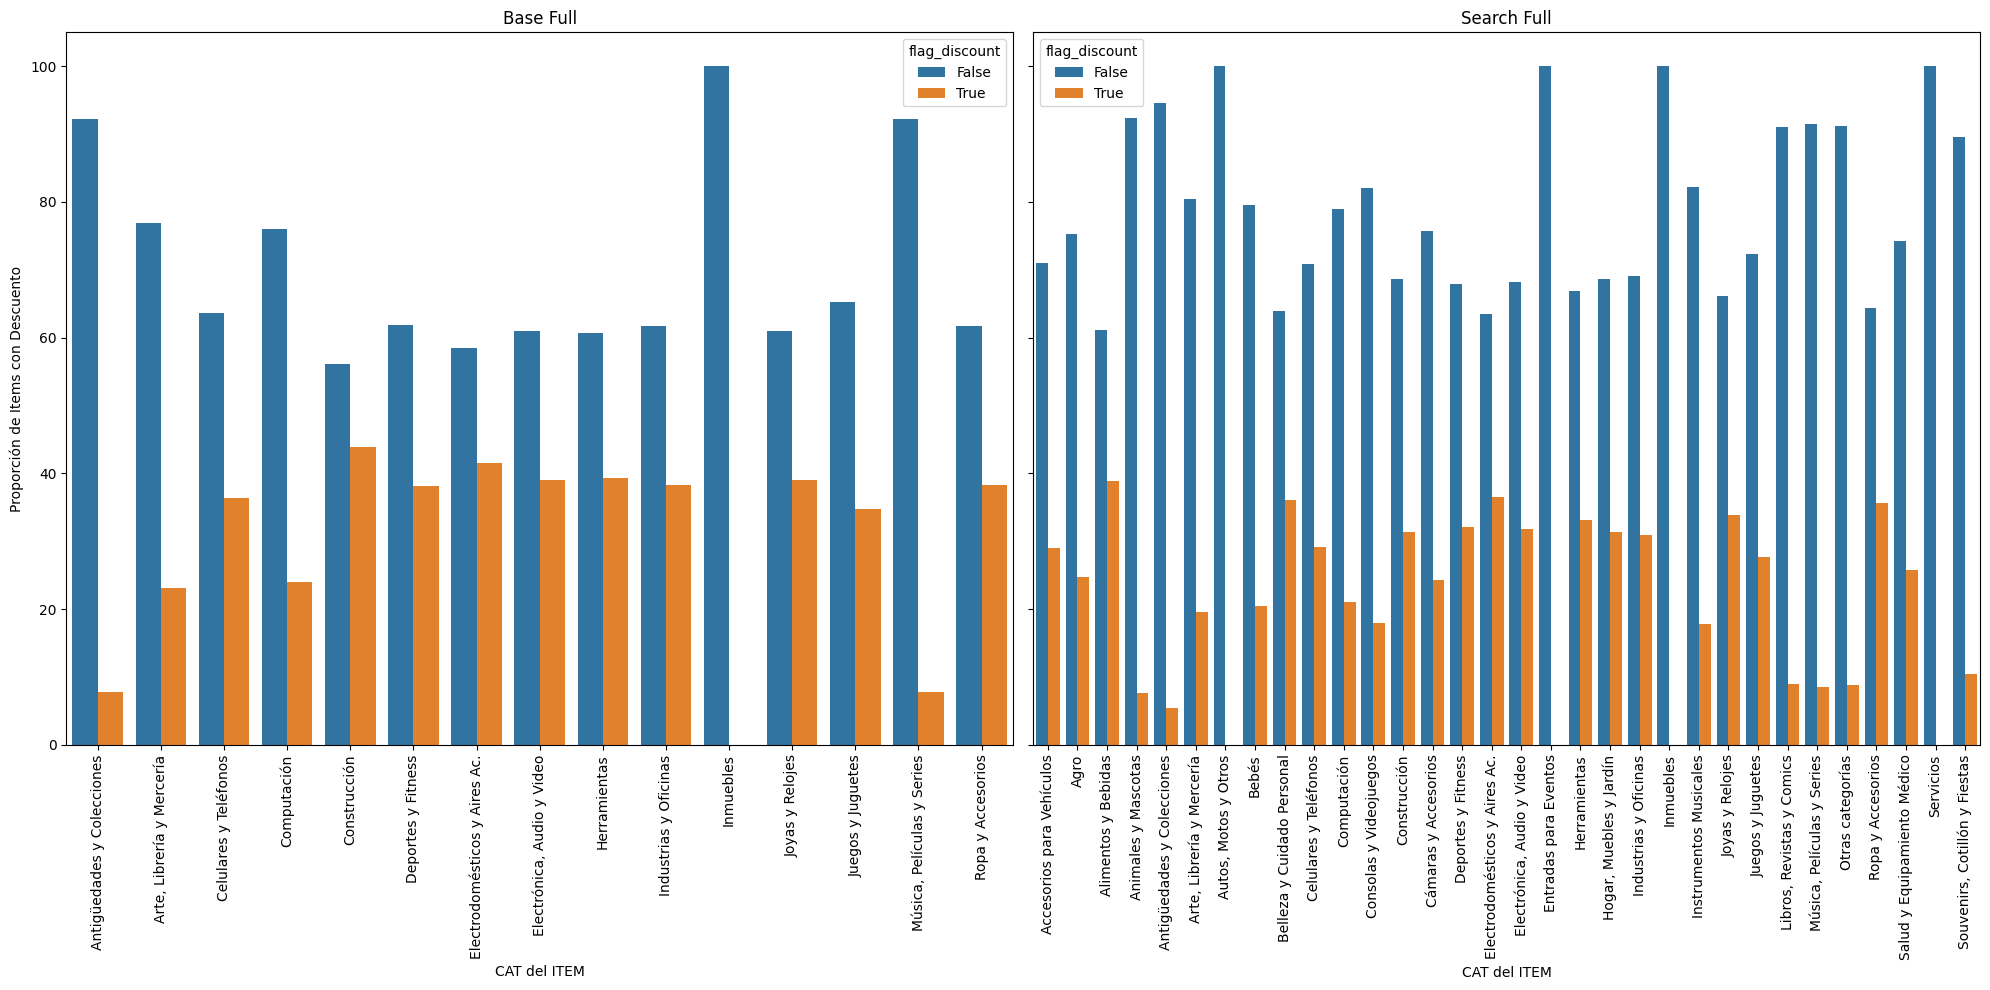

In [13]:
category_counts_base = (df_base_full.groupby(['CATEGORY_NM'])['flag_discount']
                        .value_counts(normalize=True)
                        .rename('%')
                        .mul(100)
                        .reset_index()
                        .sort_values('CATEGORY_NM'))

category_counts_search = (df_search_full.groupby(['CATEGORY_NM'])['flag_discount']
                          .value_counts(normalize=True)
                          .rename('%')
                          .mul(100)
                          .reset_index()
                          .sort_values('CATEGORY_NM'))


fig, axes = plt.subplots(1, 2, figsize=(20, 10), sharey=True)


sns.barplot(ax=axes[0], x="CATEGORY_NM", y="%", hue="flag_discount", data=category_counts_base)
axes[0].set_xlabel('CAT del ITEM')
axes[0].set_ylabel('Proporción de Items con Descuento')
axes[0].set_title('Base Full')
axes[0].tick_params(axis='x', rotation=90)  

sns.barplot(ax=axes[1], x="CATEGORY_NM", y="%", hue="flag_discount", data=category_counts_search)
axes[1].set_xlabel('CAT del ITEM')
axes[1].set_title('Search Full')
axes[1].tick_params(axis='x', rotation=90)  

plt.tight_layout()

plt.show()

A partir de las gráficas, se puede argumentar lo siguiente:

* No todas las categorías incluyen productos con descuento.
* Proporción descuentos: en las categorías donde hay descuentos, la proporción de productos con descuento no excede el 50%.
* Variabilidad entre categorías: la presencia de descuentos varía significativamente entre las diferentes categorías, sugiriendo que algunos tipos de productos son más propensos a tener descuentos que otros.
* Descuentos limitados: El hecho de que ninguna categoría tenga más del 50% de sus productos en descuento indica una política de descuentos conservadora. Esto puede estar alineado con una estrategia para mantener la percepción de valor y evitar la devaluación del producto.

In [14]:
items_w_discount = df_search_full[df_search_full.flag_discount]
count_items = df_search_full.CATEGORY_NM.value_counts()
count_items_wdiscount = items_w_discount.CATEGORY_NM.value_counts()
count_items_wdiscount

CATEGORY_NM
Alimentos y Bebidas              11997
Electrodomésticos y Aires Ac.    11209
Belleza y Cuidado Personal       11005
Herramientas                     10206
Electrónica, Audio y Video        9738
Deportes y Fitness                9708
Construcción                      9521
Hogar, Muebles y Jardín           9489
Juegos y Juguetes                 8263
Celulares y Teléfonos             8259
Joyas y Relojes                   8215
Industrias y Oficinas             8060
Salud y Equipamiento Médico       7905
Accesorios para Vehículos         7677
Agro                              7200
Cámaras y Accesorios              6646
Ropa y Accesorios                 6634
Computación                       6318
Bebés                             5983
Arte, Librería y Mercería         5843
Consolas y Videojuegos            5363
Instrumentos Musicales            5301
Libros, Revistas y Comics         2623
Música, Películas y Series        2604
Animales y Mascotas               2325
Souvenirs, Co

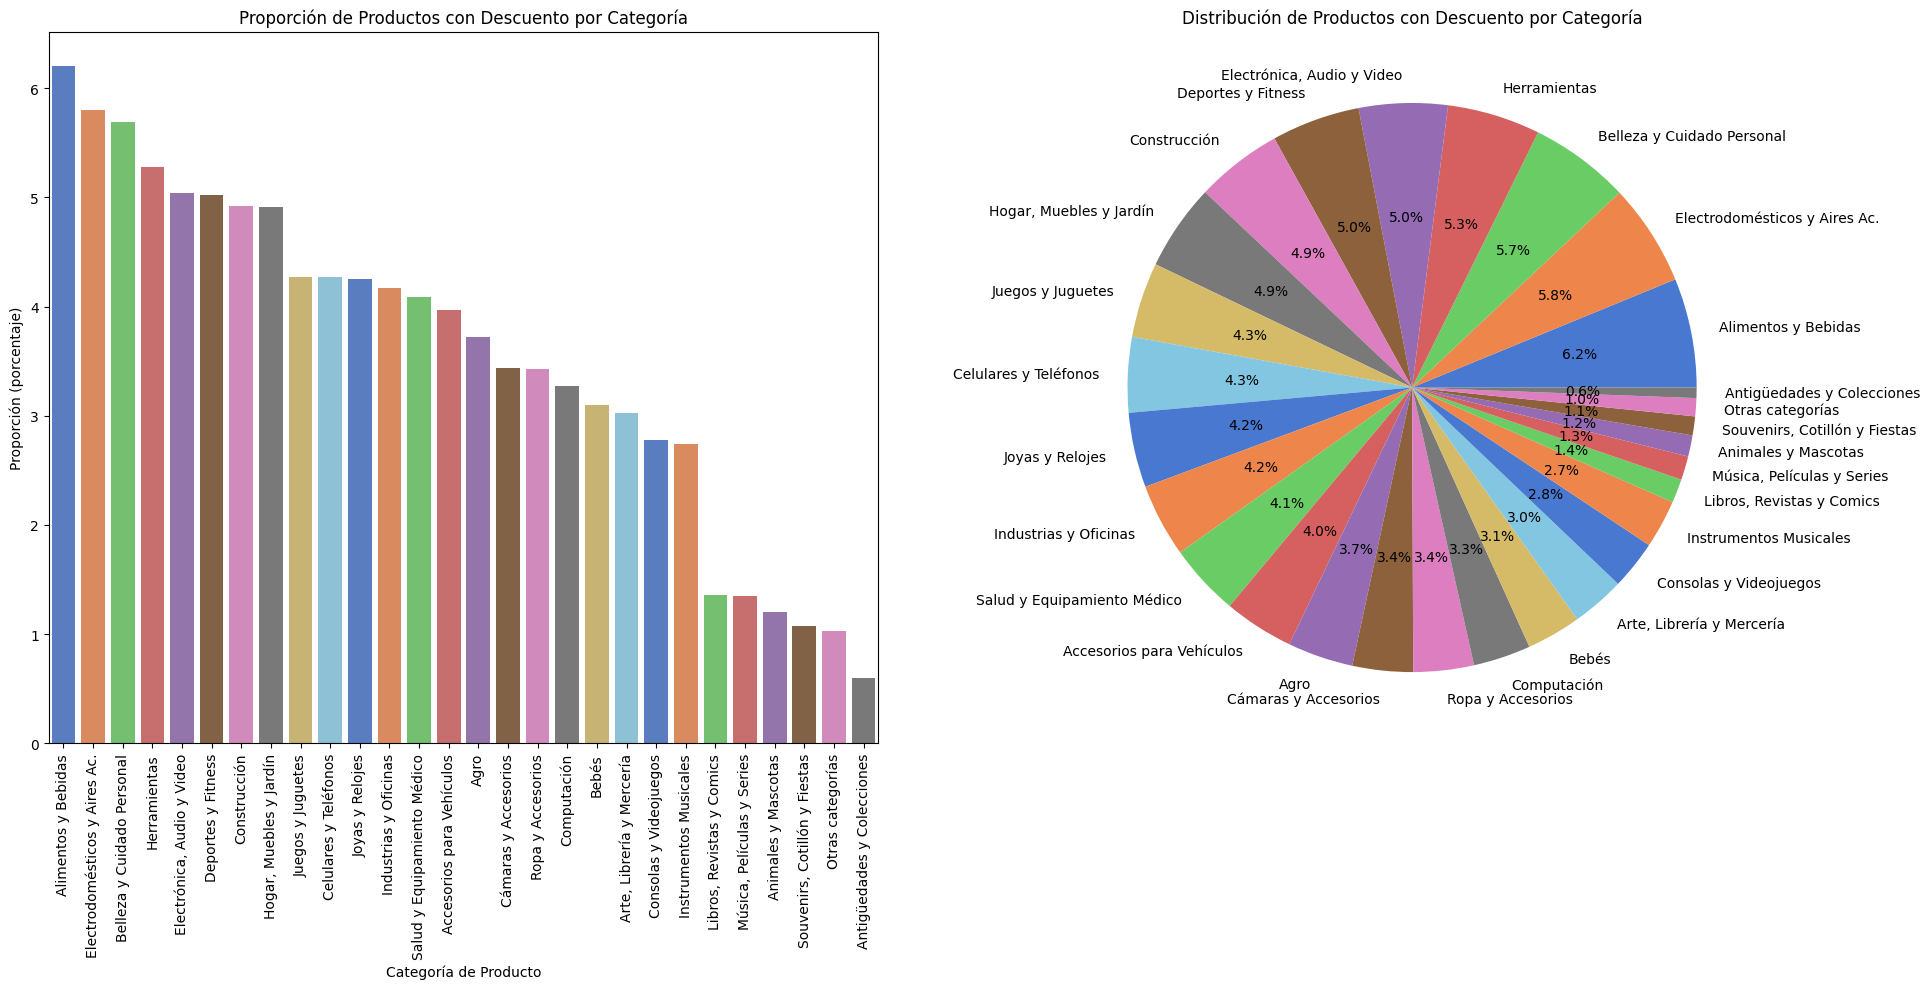

In [15]:
category_discount = pd.DataFrame(items_w_discount.CATEGORY_NM.value_counts() / len(items_w_discount) * 100).reset_index()
category_discount.columns = ['CATEGORY_NM', 'count']

fig, axes = plt.subplots(1, 2, figsize=(20, 10))

ax1 = sns.barplot(ax=axes[0], x='CATEGORY_NM', y='count', data=category_discount, ci=None, palette="muted", orient='v')
_ = plt.setp(ax1.get_xticklabels(), rotation=90)  
ax1.set_xlabel('Categoría de Producto')
ax1.set_ylabel('Proporción (porcentaje)')
ax1.set_title('Proporción de Productos con Descuento por Categoría')

ax2 = axes[1]
ax2.pie(category_discount['count'], labels=category_discount['CATEGORY_NM'], autopct='%1.1f%%', colors=sns.color_palette("muted"))
ax2.set_title('Distribución de Productos con Descuento por Categoría')

plt.tight_layout()

plt.show()


De las gráficas se observa que la categoría de "ALimentos y Bebidas" es la categoría con mayor número de items con descuentos (6.2%) y la categoría "Antigüedades y Colecciones" la que menos items con descuento tiene (0.6%). Si bien el número de items con descuento es proporcional a la oferta (# de publicaciones), se evidencia que los items de "consumo diario" como: alimentos, electrodomésticos, belleza/cuidado personal, tecnología, deporte dominan en el top de descuentos, lo cuál es un indicador fuerte de la demanda que tienen este tipo de porductos.

In [16]:
round(count_items_wdiscount['Celulares y Teléfonos'] / count_items['Celulares y Teléfonos'] * 100 ,0)

29.0

## R2 - Descuentos en categoría específica
El 29 % de Celulares y Teléfonos tienen descuento en Mayo

## R3 - Descuento Promedio

In [17]:
items_w_discount['vlr_descuento'] = 1 - items_w_discount['price']/items_w_discount['original_price']
items_w_discount.sample(2)

,id_item,title,price,original_price,available_quantity,buying_mode,listing_type_id,accepts_mercadopago,CATEGORIA_CODE,condition,shipping.free_shipping,catalog_listing,CATEGORY_NM,flag_discount,vlr_descuento
2350,MLA836325161,Auriculares Audio-technica M-series Ath-m20x N...,142139.0,142139.0,50,buy_it_now,gold_pro,True,MLA1000,new,True,True,"Electrónica, Audio y Video",True,0.0
364708,MLA1409639879,Pañales Pampers Pants Ajuste Total G,15470.0,15470.0,1,buy_it_now,gold_special,True,MLA1384,new,False,True,Bebés,True,0.0


In [18]:
items_w_discount['vlr_descuento'].describe()

count    193300.000000
mean          0.186894
std           0.163167
min           0.000000
25%           0.050000
50%           0.140000
75%           0.281993
max           0.786421
Name: vlr_descuento, dtype: float64

* Número de ítems con descuento - Count: hay 193,300 ítems con descuento.

* Descuento promedio - Mean: el descuento promedio es de aproximadamente 18.69%. Esto indica que, en general, los descuentos aplicados no son extremadamente altos, sino que se sitúan en un rango moderado.

* Variabilidad del descuento - Std (Desviación estándar): la desviación estándar es 16.32%, lo que sugiere una variabilidad moderada en los descuentos aplicados. Algunos productos tienen descuentos significativamente mayores o menores que el promedio.

* Descuento Min: El descuento mínimo es 0%, lo cual puede indicar que algunos ítems están listados como con descuento, pero en realidad no tienen descuento efectivo.

* Descuento Max: El descuento máximo es 78.64%. Aunque existen ítems con descuentos muy elevados, estos son casos menos comunes.

*Distribución de los descuentos*

- 25% Percentil: el 25% de los ítems tienen un descuento de hasta 5%. Esto significa que 1/4 de los ítems tienen descuentos muy bajos.
- Mediana (50% Percentil): la mediana es 14%. La mitad de los ítems tienen un descuento menor o igual al 14%, lo que indica que la mayoría de los descuentos son inferiores al promedio.
- 75% Percentil: el 75% de los ítems tienen un descuento de hasta aproximadamente 28.20%. Solo el 25% de los ítems tienen descuentos superiores a este valor.

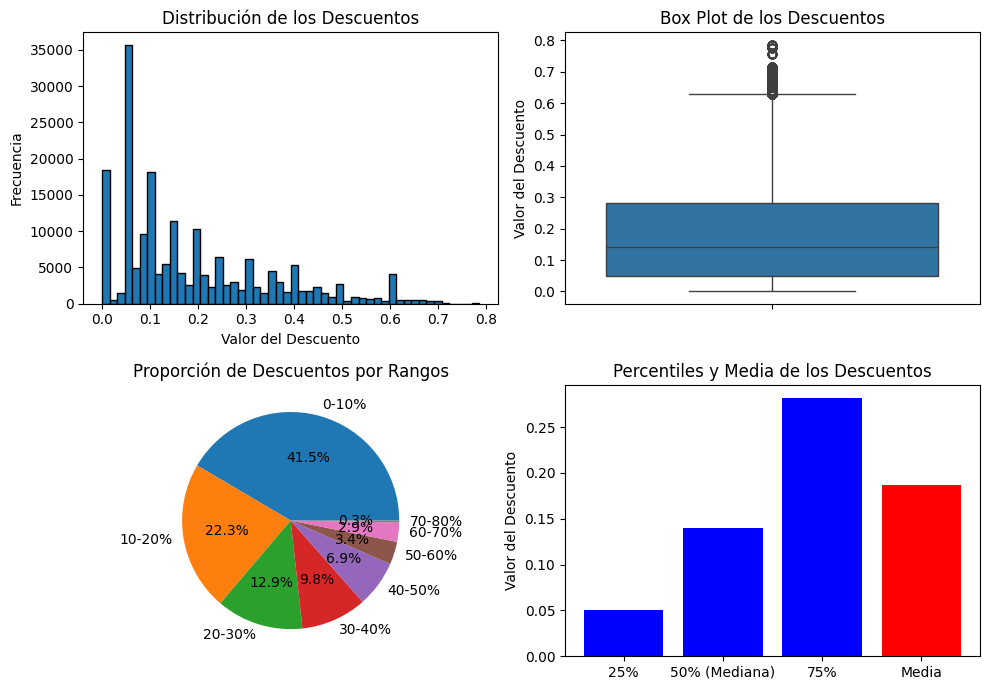

In [19]:
items_w_discount_VALUES = items_w_discount['vlr_descuento'].values

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 7))

axes[0, 0].hist(items_w_discount_VALUES, bins=50, edgecolor='black')
axes[0, 0].set_title('Distribución de los Descuentos')
axes[0, 0].set_xlabel('Valor del Descuento')
axes[0, 0].set_ylabel('Frecuencia')

sns.boxplot(items_w_discount_VALUES, ax=axes[0, 1])
axes[0, 1].set_title('Box Plot de los Descuentos')
axes[0, 1].set_ylabel('Valor del Descuento')

bins = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
labels = ['0-10%', '10-20%', '20-30%', '30-40%', '40-50%', '50-60%', '60-70%', '70-80%']
hist, _ = np.histogram(items_w_discount_VALUES, bins=bins)
axes[1, 0].pie(hist, labels=labels, autopct='%1.1f%%')
axes[1, 0].set_title('Proporción de Descuentos por Rangos')


percentiles = [0.25, 0.50, 0.75]
values = [np.percentile(items_w_discount_VALUES, p*100) for p in percentiles]
mean_value = np.mean(items_w_discount_VALUES)

axes[1, 1].bar(['25%', '50% (Mediana)', '75%', 'Media'], values + [mean_value], color=['blue', 'blue', 'blue', 'red'])
axes[1, 1].set_title('Percentiles y Media de los Descuentos')
axes[1, 1].set_ylabel('Valor del Descuento')

fig.tight_layout()

plt.show()

*INTERPRETACIÓN*
* Distribución de descuentos bajos a moderados: La mayoría de los descuentos son bajos a moderados, con un promedio alrededor del 18.69% y una mediana del 14%. Esto sugiere que los descuentos más comunes no son extremadamente altos.
* Presencia de descuentos altos: Aunque existen descuentos altos (hasta el 78.64%), son menos frecuentes, lo que se refleja en el hecho de que el 75% de los ítems tienen descuentos menores al 28.20%.
* Variabilidad considerable: La variabilidad en los descuentos es notable, lo cual puede ser indicativo de diferentes estrategias de descuento dependiendo de los productos o la demanda.

In [20]:
print('Valor Promedio de Descuento por Categoría')
items_w_discount[['CATEGORY_NM', 'vlr_descuento']].groupby('CATEGORY_NM').mean().sort_values(by='vlr_descuento', ascending=False)

Valor Promedio de Descuento por Categoría


,vlr_descuento
CATEGORY_NM,
Belleza y Cuidado Personal,0.237757
"Hogar, Muebles y Jardín",0.237169
Electrodomésticos y Aires Ac.,0.230236
Herramientas,0.220292
Alimentos y Bebidas,0.219770
Construcción,0.211742
Bebés,0.208977
Juegos y Juguetes,0.206878
Joyas y Relojes,0.203859


# R4. Descuentos | Precio

In [21]:
items_w_discount_PRICE = items_w_discount.dropna(subset=['original_price', 'vlr_descuento'])

correlation = items_w_discount_PRICE['original_price'].corr(items_w_discount_PRICE['vlr_descuento'])
print(f"Correlación entre el precio original y el valor del descuento: {correlation}")

Correlación entre el precio original y el valor del descuento: 0.06617334540722272


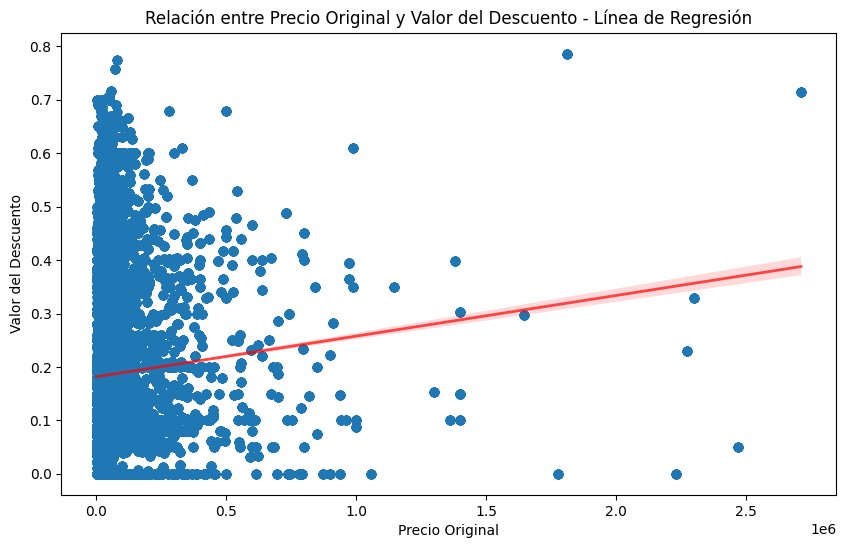

In [22]:
plt.figure(figsize=(10, 6))
sns.regplot(x='original_price', y='vlr_descuento', data=items_w_discount_PRICE, line_kws={"color":"r","alpha":0.7,"lw":2})
plt.title('Relación entre Precio Original y Valor del Descuento - Línea de Regresión')
plt.xlabel('Precio Original')
plt.ylabel('Valor del Descuento')
plt.show()

Relación Débil -> una pendiente baja sugiere que hay una relación débil entre el precio original y el valor del descuento. En otras palabras, a medida que el precio original de los productos aumenta, el valor del descuento no aumenta significativamente.

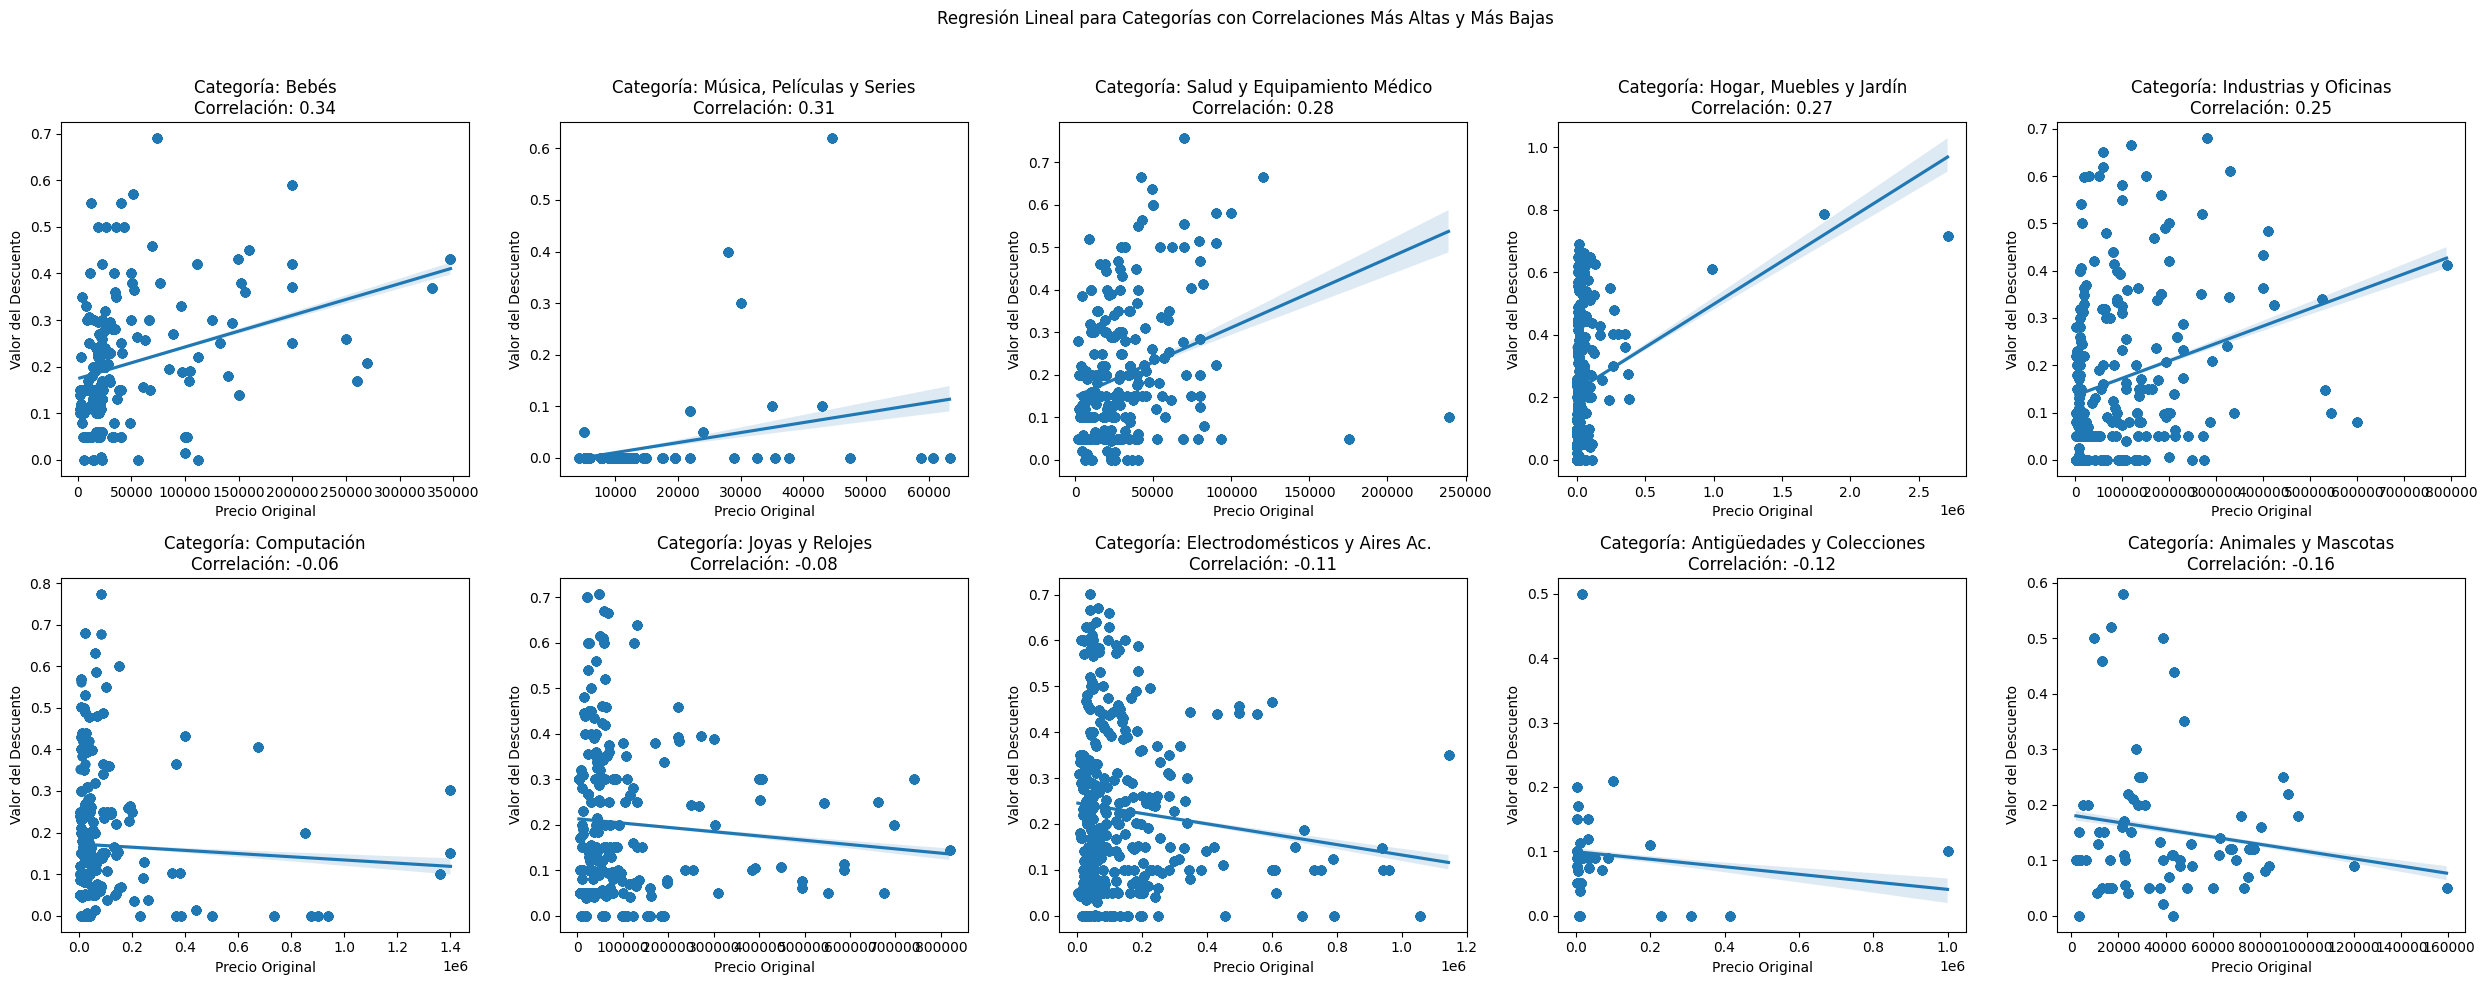

In [23]:
correlation_by_category = items_w_discount.groupby('CATEGORY_NM').apply(
    lambda x: x['original_price'].corr(x['vlr_descuento'])
).reset_index()
correlation_by_category.columns = ['CATEGORY_NM', 'correlation']

correlation_by_category = correlation_by_category.sort_values(by='correlation', ascending=False)

# TOP 5 correlaciones altas
top_4_highest = correlation_by_category.head(5)
top_4_lowest = correlation_by_category.tail(5)

fig, axes = plt.subplots(2, 5, figsize=(25, 10))
fig.suptitle('Regresión Lineal para Categorías con Correlaciones Más Altas y Más Bajas')

def plot_category(category, ax):
    subset = items_w_discount[items_w_discount['CATEGORY_NM'] == category]
    sns.regplot(x='original_price', y='vlr_descuento', data=subset, ax=ax)
    ax.set_title(f'Categoría: {category}\nCorrelación: {subset["original_price"].corr(subset["vlr_descuento"]):.2f}')
    ax.set_xlabel('Precio Original')
    ax.set_ylabel('Valor del Descuento')

for i, category in enumerate(top_4_highest['CATEGORY_NM']):
    plot_category(category, axes[0, i])

for i, category in enumerate(top_4_lowest['CATEGORY_NM']):
    plot_category(category, axes[1, i])

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


* Correlación Positiva: las categorías con valores de correlación positivos indican que, a medida que el precio original aumenta, el valor del descuento también tiende a aumentar. Por ejemplo, en la categoría "Bebés" con una correlación de 0.337, hay una relación positiva moderada entre el precio original y el valor del descuento.
* Correlación Negativa: las categorías con valores de correlación negativos sugieren que, a medida que el precio original aumenta, el valor del descuento tiende a disminuir. Por ejemplo, "Animales y Mascotas" con una correlación de -0.157 muestra una relación negativa débil.
* Correlación Baja o Cero: las categorías con valores cercanos a 0 indican poca o ninguna relación entre el precio original y el valor del descuento. Por ejemplo, "Consolas y Videojuegos" con una correlación de 0.046.

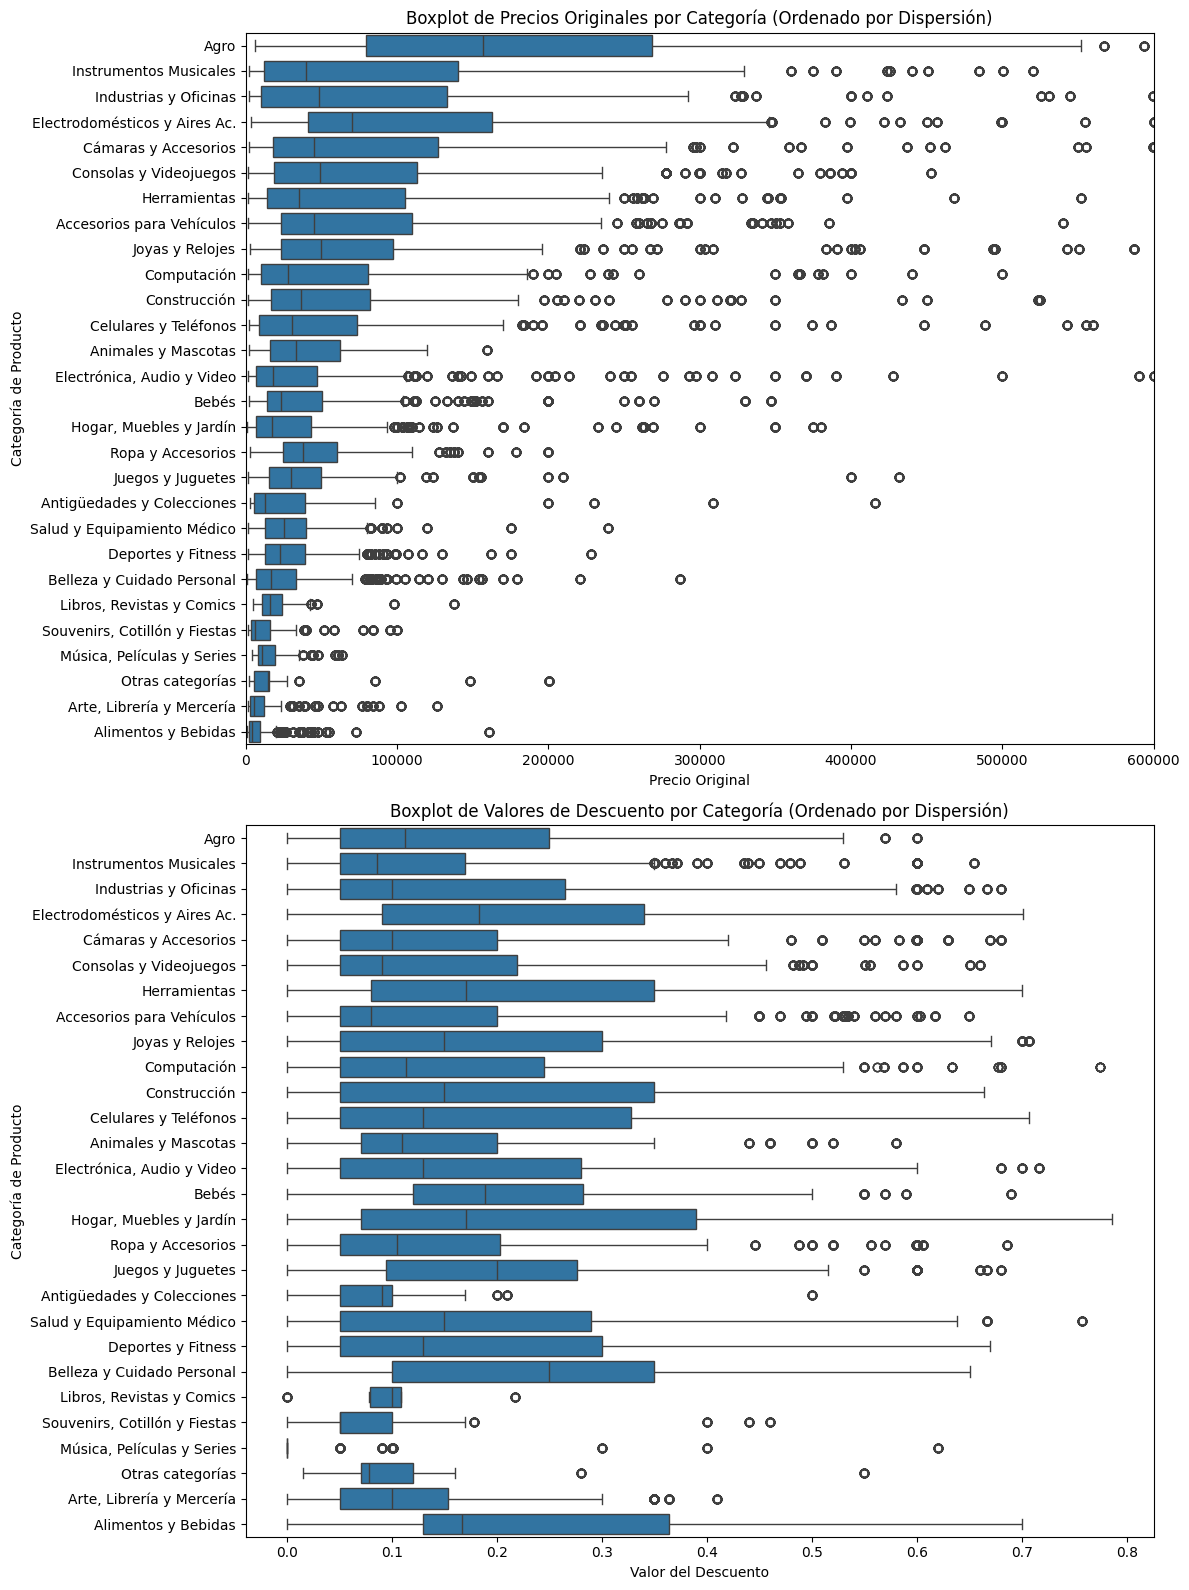

In [27]:
# IQR para cada CAT -> luego order
iqr_df = items_w_discount.groupby('CATEGORY_NM')['original_price'].agg(
    Q1=lambda x: x.quantile(0.25),
    Q3=lambda x: x.quantile(0.75)
).reset_index()
iqr_df['IQR'] = iqr_df['Q3'] - iqr_df['Q1']

iqr_df = iqr_df.sort_values(by='IQR', ascending=False)
ordered_categories = iqr_df['CATEGORY_NM'].tolist()

items_w_discount['CATEGORY_NM_ordered'] = pd.Categorical(
    items_w_discount['CATEGORY_NM'], 
    categories=ordered_categories, 
    ordered=True
)

fig, axes = plt.subplots(2, 1, figsize=(12, 16))

# Boxplot
sns.boxplot(
    y="CATEGORY_NM_ordered", 
    x="original_price", 
    data=items_w_discount, 
    orient="h", 
    ax=axes[0]
)
axes[0].set_title('Boxplot de Precios Originales por Categoría (Ordenado por Dispersión)')
axes[0].set_xlabel('Precio Original')
axes[0].set_ylabel('Categoría de Producto')
axes[0].set_xlim((0, 6e5))  


sns.boxplot(
    y="CATEGORY_NM_ordered", 
    x="vlr_descuento", 
    data=items_w_discount, 
    orient="h", 
    ax=axes[1]
)
axes[1].set_title('Boxplot de Valores de Descuento por Categoría (Ordenado por Dispersión)')
axes[1].set_xlabel('Valor del Descuento')
axes[1].set_ylabel('Categoría de Producto')

plt.tight_layout()
plt.show()


# R5 Vendedores - Descuentos

In [28]:
sample_discounts_search = df_base_full[df_search_full.flag_discount]
sample_discounts_search['fecha_update'] = pd.to_datetime(sample_discounts_search['date_created'], format='%Y-%m-%dT%H:%M:%S.%fZ')
sample_discounts_search['vlr_descuento'] = 1 - sample_discounts_search['PRICE']/sample_discounts_search['ORIGINAL_PRICE']
sample_discounts_search.loc[sample_discounts_search['seller_reputation.power_seller_status'].isna(), 'seller_reputation.power_seller_status'] = 'WO_STATUS'
sample_discounts_search.sample(3)

,ID,TITLE,PRICE,ORIGINAL_PRICE,AVAILABLE_QUANTITY,BUYING_MODE,LISTING_TYPE_ID,ACCEPTS_MERCADOPAGO,CATEGORIA_CODE,condition,...,date_created,seller.id,seller.nickname,seller_reputation.level_id,seller_reputation.power_seller_status,seller_reputation.transactions.total,CATEGORY_NM,flag_discount,fecha_update,vlr_descuento
19834,MLA1516550062,Mosqueton Carabinero Doble Traba Seguridad 10 ...,22999.0,NaN,1,buy_it_now,gold_special,1,MLA1276,new,...,2023-09-23T09:08:56.000Z,13647702,LIBERCAM,5_green,platinum,733588,Deportes y Fitness,False,2023-09-23 09:08:56,NaN
11726,MLA1397956121,Smartwatch Kieslect Ks Pro Negro 2.01 Llamadas...,98772.0,NaN,1,buy_it_now,gold_pro,1,MLA3937,new,...,2023-12-04T14:10:05.000Z,164378523,TIENDADENDA,5_green,platinum,10389,Joyas y Relojes,False,2023-12-04 14:10:05,NaN
9967,MLA1379303233,Dispenser Simple De Pared Baño Para Shampoo Ja...,7614.0,12790.0,1,buy_it_now,gold_special,1,MLA1499,new,...,2023-07-24T19:12:26.000Z,142125695,TECNOFAST_,5_green,platinum,542625,Industrias y Oficinas,True,2023-07-24 19:12:26,0.404691


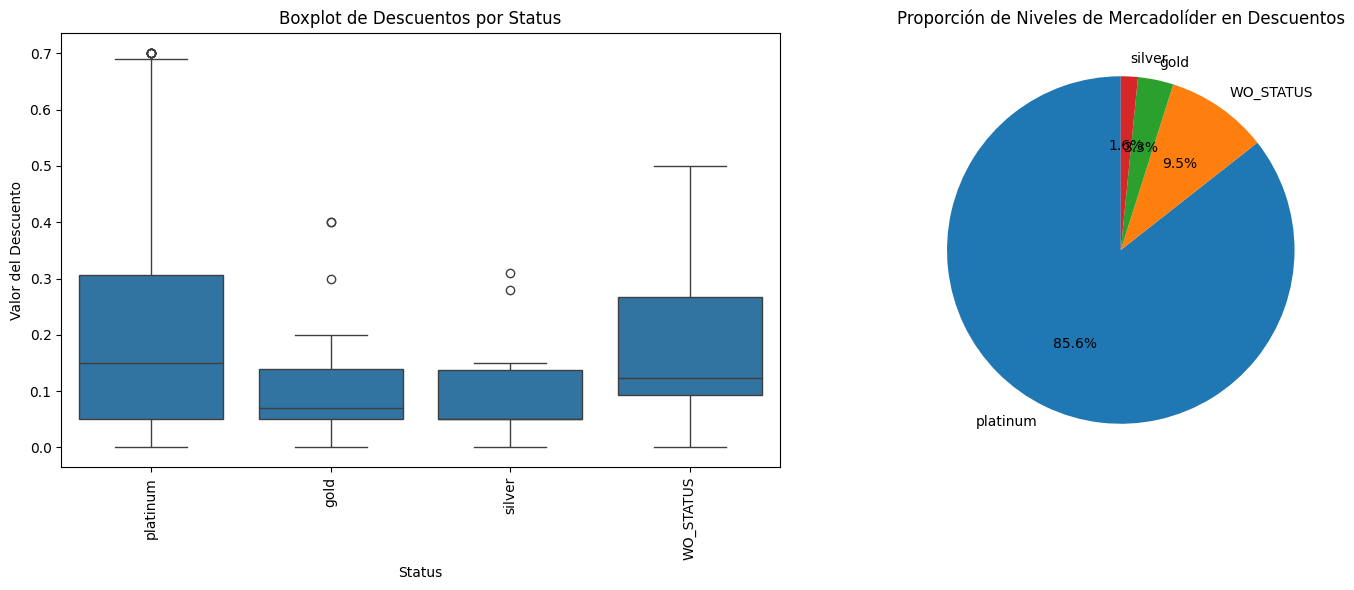

In [29]:
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)  
ax1 = sns.boxplot(x="seller_reputation.power_seller_status", y="vlr_descuento", data=sample_discounts_search, 
                  order=['platinum', 'gold', 'silver', 'WO_STATUS'])
plt.title('Boxplot de Descuentos por Status')
plt.xlabel('Status')
plt.ylabel('Valor del Descuento')
_ = plt.setp(ax1.get_xticklabels(), rotation=90)


plt.subplot(1, 2, 2)  
status_counts = sample_discounts_search['seller_reputation.power_seller_status'].value_counts()
labels = status_counts.index
plt.pie(status_counts, labels=labels, autopct='%1.1f%%', startangle=90)
plt.title('Proporción de Niveles de Mercadolíder en Descuentos')
plt.ylabel('')

plt.tight_layout()

plt.show()


La mayoría de los descuentos se concentran en el Status = Platinum. Siendo Platinum el status superior dentro de los MercadoLíderes. Los vendedores que alcanzan este nivel suelen tener un volumen alto de ventas. A pesar de no contar con la variable "sold_quantity" en el dataset, el análisis realizado valida que existe una alta correlación entre el número de ventas y los descuentos ofrecidos por los vendedores. 

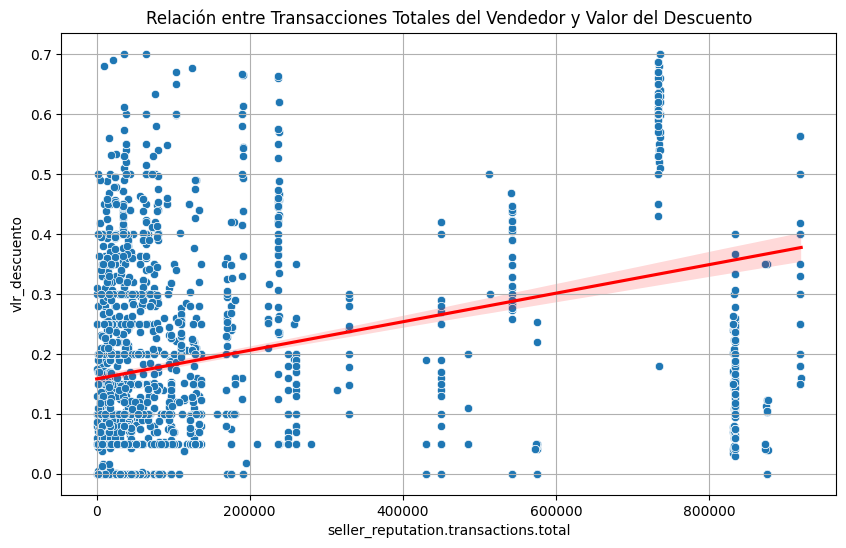

Correlación entre Transacciones Totales del Vendedor y Valor del Descuento: 0.36


In [34]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='seller_reputation.transactions.total', y='vlr_descuento', data=sample_discounts_search)
plt.title('Relación entre Transacciones Totales del Vendedor y Valor del Descuento')
plt.xlabel('Total de Transacciones del Vendedor')
plt.ylabel('Valor del Descuento')
plt.grid(True)

sns.regplot(x='seller_reputation.transactions.total', y='vlr_descuento', data=sample_discounts_search, scatter=False, color='red')

plt.show()

correlation = sample_discounts_search['seller_reputation.transactions.total'].corr(sample_discounts_search['vlr_descuento'])
print(f"Correlación entre Transacciones Totales del Vendedor y Valor del Descuento: {round(correlation,2)}")


# EXTRA (TIME ANALYTICS)

In [54]:
sample_discounts_search['dias'] = sample_discounts_search['fecha_update'].dt.day

descuentos_analisis = sample_discounts_search.groupby('dias')['vlr_descuento'].describe()
descuentos_analisis

,count,mean,std,min,25%,50%,75%,max
dias,,,,,,,,
1,63.0,0.198100,0.162812,0.00,0.070176,0.120000,0.300000,0.600017
2,103.0,0.215488,0.175723,0.00,0.054552,0.200000,0.300000,0.630000
3,70.0,0.197616,0.203535,0.00,0.050000,0.131819,0.226795,0.700039
4,113.0,0.242830,0.186737,0.00,0.090000,0.199215,0.364001,0.664013
5,79.0,0.223538,0.168225,0.00,0.084322,0.177968,0.345462,0.600044
6,74.0,0.163162,0.125301,0.00,0.072500,0.150000,0.200000,0.599820
7,88.0,0.193747,0.144744,0.00,0.097500,0.149977,0.300000,0.640000
8,76.0,0.256507,0.226032,0.00,0.050000,0.199496,0.436914,0.686392
9,88.0,0.235913,0.183103,0.00,0.071429,0.200000,0.364000,0.630000


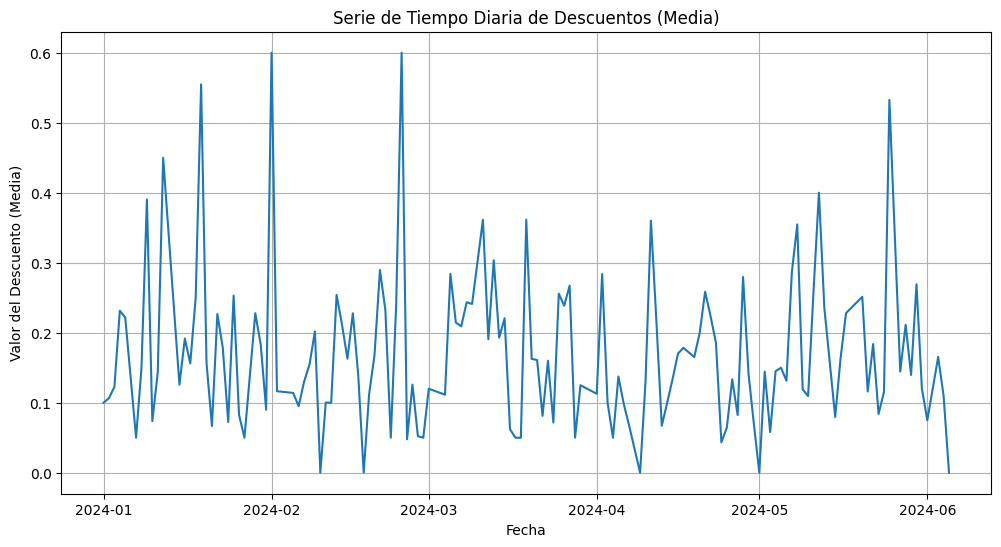

In [69]:
# Suponiendo que 'fecha_update' ya está en formato datetime y 'vlr_descuento2' es la columna de descuentos

# Crear una copia del DataFrame original para evitar modificaciones no deseadas
sample_discounts_search_cp = sample_discounts_search.copy()

# Establecer 'fecha_update' como índice para facilitar el manejo de fechas
sample_discounts_search_cp['fecha_update'] = pd.to_datetime(sample_discounts_search_cp['fecha_update'])
sample_discounts_search_cp = sample_discounts_search_cp[sample_discounts_search_cp['fecha_update'].dt.year >= 2024]
sample_discounts_search_cp.set_index('fecha_update', inplace=True)

# Agregar datos por día y calcular la media del valor del descuento
df_diario = sample_discounts_search_cp['vlr_descuento'].resample('D').mean()

# Plotear serie de tiempo diaria de los descuentos
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_diario)
plt.title('Serie de Tiempo Diaria de Descuentos (Media)')
plt.xlabel('Fecha')
plt.ylabel('Valor del Descuento (Media)')
plt.grid(True)
plt.show()


In [86]:
sample_discounts_search_cp

,ID,TITLE,PRICE,ORIGINAL_PRICE,AVAILABLE_QUANTITY,BUYING_MODE,LISTING_TYPE_ID,ACCEPTS_MERCADOPAGO,CATEGORIA_CODE,condition,...,seller.nickname,seller_reputation.level_id,seller_reputation.power_seller_status,seller_reputation.transactions.total,CATEGORY_NM,flag_discount,vlr_descuento,dias,dia_semana,dia_num
fecha_update,,,,,,,,,,,,,,,,,,,,,
2024-05-10 15:15:45-03:00,MLA1425909273,Auriculares Bluetooth In-ear Gamer F9-5 Negro ...,7599.0,9999.0,500,buy_it_now,gold_pro,1,MLA1000,new,...,OVERHARD,5_green,platinum,175126,"Electrónica, Audio y Video",True,0.240024,10,Viernes,NaN
2024-01-09 11:04:51-03:00,MLA1401747599,Auricular In-ear Gamer Inalámbrico Fan Pro F10...,7377.6,11600.0,500,buy_it_now,gold_special,1,MLA1000,new,...,IMPORTACIONES XPROSRL,5_green,platinum,46029,"Electrónica, Audio y Video",True,0.364000,9,Martes,NaN
2024-01-22 11:03:50-03:00,MLA1403581669,Auriculares In-ear Gamer Inalámbricos Alpina G...,7404.0,9900.0,500,buy_it_now,gold_pro,1,MLA1000,new,...,ALPINA ARG,5_green,platinum,224292,"Electrónica, Audio y Video",True,0.252121,22,Lunes,NaN
2024-03-04 15:27:56-03:00,MLA1412822917,Batería Pila Cr2032 Pack De 5 Pilas 3v. 220 Mah,3465.6,3648.0,150,buy_it_now,gold_special,1,MLA1000,new,...,EQUIP STORE,5_green,platinum,12115,"Electrónica, Audio y Video",True,0.050000,4,Lunes,NaN
2024-06-03 23:34:45.781000-03:00,MLA1797141970,Google Chromecast 3 Full Hd Media Streaming Negro,53700.0,89500.0,500,buy_it_now,gold_pro,1,MLA1000,new,...,HYT.COM.AR,5_green,platinum,45825,"Electrónica, Audio y Video",True,0.400000,4,Lunes,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04-03 17:05:16-03:00,MLA1729488566,Mochila Porta Notebook Alpina 1322 1322 Color ...,50400.0,NaN,500,buy_it_now,gold_special,1,MLA1648,new,...,ALPINA ARG,5_green,platinum,224001,Computación,False,NaN,3,Miércoles,NaN
2024-04-16 16:28:20-03:00,MLA1422070773,Tablet Con Funda Positivo Bgh Twist Tab T790 ...,89999.0,119999.0,250,buy_it_now,gold_pro,1,MLA1648,new,...,MERCADOLIBRE ELECTRONICA_AR,5_green,platinum,830869,Computación,True,0.250002,16,Martes,NaN
2024-03-11 10:54:44-03:00,MLA1699382944,Samsung Galaxy Tab A9 64gb 4gb Ram Color Graphite,349999.0,NaN,1,buy_it_now,gold_pro,1,MLA1648,new,...,MERCADOLIBRE ELECTRONICA_AR,5_green,platinum,830869,Computación,False,NaN,11,Lunes,NaN


In [87]:
sample_discounts_search_cp['dia_semana'].unique()

array(['Viernes', 'Martes', 'Lunes', 'Domingo', 'Jueves', 'Miércoles',
       'Sábado'], dtype=object)

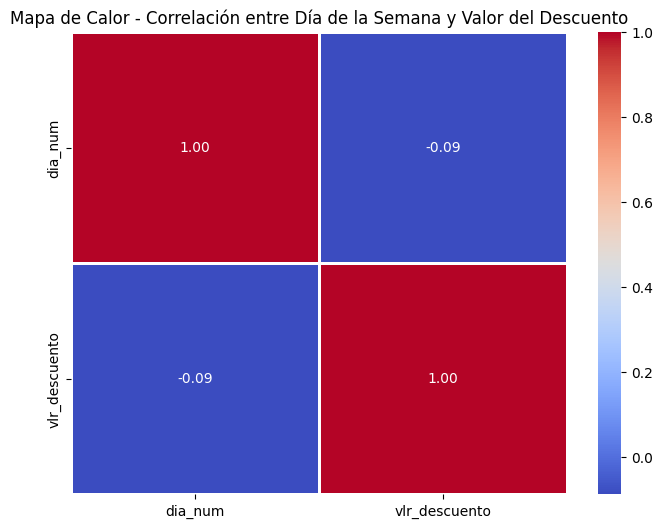

In [90]:
dias_semana = {
    'Lunes': 0,
    'Martes': 1,
    'Miércoles': 2,
    'Jueves': 3,
    'Viernes': 4,
    'Sábado': 5,
    'Domingo': 6
}

sample_discounts_search_cp['dia_num'] = sample_discounts_search_cp['dia_semana'].map(dias_semana)

correlation_matrix = sample_discounts_search_cp[['dia_num', 'vlr_descuento']].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=1, linecolor='white')
plt.title('Mapa de Calor - Correlación entre Día de la Semana y Valor del Descuento')
plt.show()